In [18]:
import importlib
import func
importlib.reload(func)
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.feature_selection import VarianceThreshold
pd.options.display.max_rows = 100
%matplotlib inline
importlib.reload(func)
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn import svm
from sklearn.svm import NuSVC
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn.metrics import precision_recall_fscore_support
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids

In [19]:
df_101_tier = pd.read_excel("data/df_tierc700.xlsx")
# df_101_tier = df_101_tier.set_index("RTN")

In [20]:
df_101_tier.shape

(8599, 397)

In [21]:
df_101_tier.head()

,A1,A2,A2A,A2B,A3,A3A,A3B,A3C,A3D,B6,...,CVOC,ERROR,METAL,O/HM,OTHER,PAH,PCB,PETROLEUM,UNKNOWN,VOC
1-0017194,1,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1-0017315,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1-0017321,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1-0017322,1,0,0,0,1,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1-0017326,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


## 1. Use all features and Oversampling

In [22]:
X = df_101_tier.drop("Tier1D", axis=1)
y = df_101_tier["Tier1D"]
# y = df_101_tier["IRA"]

In [23]:
y.groupby(y).count()

Tier1D
Non-Tier1D        7565
Persist-Tier1D    1034
Name: Tier1D, dtype: int64

### 1.1 Use Random Forest to extract features

In [24]:
# Use random forest to extract useful features
# Use all the data
rfmodel = RandomForestClassifier(n_estimators=500, n_jobs=-1, class_weight='balanced')
rfmodel.fit(X, y)
feat_import = pd.DataFrame({"Feature": X.columns, "Importance": rfmodel.feature_importances_})\
        .sort_values("Importance", ascending=False)
feat20 = feat_import.iloc[:20, 0].tolist()

In [25]:
feat20

['D10A',
 'H3',
 'D6A',
 'G4',
 'D9E',
 'D10J',
 'H13AVOLUME',
 'C6E',
 'F12',
 'A1',
 'METAL',
 'D8A',
 'D9L',
 'CVOC',
 'PETROLEUM',
 'D4M',
 'H16',
 'B6',
 'D8B',
 'D10I']

### 1.2 Use all features to model

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X.loc[:, feat20[:20]], 
                                                    y, 
                                                    test_size=0.25,
                                                    stratify=y,
                                                    random_state=1634)
labels = ["Persist-Tier1D", "Non-Tier1D"]

In [28]:
X_train, y_train = SMOTE().fit_sample(X_train, y_train)
print(X_train.shape)
print(Counter(y_train).items())
print(X_train.shape)
print("Training size: %r" %X_train.shape[0])
print("Test size: %r" %X_test.shape[0])

(11348, 20)
dict_items([('Non-Tier1D', 5674), ('Persist-Tier1D', 5674)])
(11348, 20)
Training size: 11348
Test size: 2150


Confusion matrix, without normalization
[[ 293   91]
 [ 702 1086]]
             precision    recall  f1-score   support

     Tier1D       0.29      0.76      0.42       384
 Non-Tier1D       0.92      0.61      0.73      1788

avg / total       0.81      0.63      0.68      2172



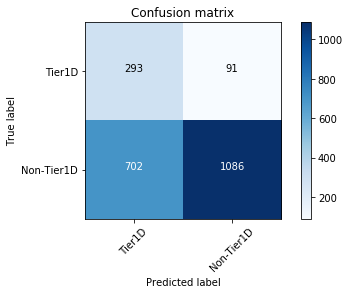

In [11]:
ab = AdaBoostClassifier(learning_rate=0.05, n_estimators=500)
ab.fit(X_train, y_train)
y_predict = ab.predict(X_test)
func.plot_confusion_matrix(confusion_matrix(y_test, y_predict, labels=labels), classes=labels)
print(classification_report(y_test, y_predict, labels=labels, target_names=labels))

Confusion matrix, without normalization
[[ 286   98]
 [ 735 1053]]
             precision    recall  f1-score   support

     Tier1D       0.28      0.74      0.41       384
 Non-Tier1D       0.91      0.59      0.72      1788

avg / total       0.80      0.62      0.66      2172



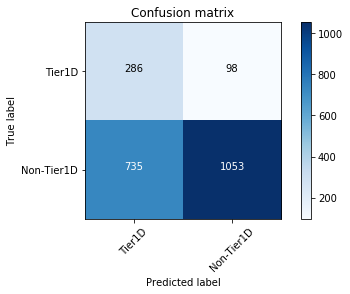

In [12]:
rf = RandomForestClassifier(max_depth=3, n_estimators=500, max_features=0.2, n_jobs=-1)
rf.fit(X_train, y_train)
y_predict = rf.predict(X_test)
func.plot_confusion_matrix(confusion_matrix(y_test, y_predict, labels=labels), classes=labels)
print(classification_report(y_test, y_predict, labels=labels, target_names=labels))

Confusion matrix, without normalization
[[ 222   37]
 [1103  788]]
                precision    recall  f1-score   support

Persist-Tier1D       0.17      0.86      0.28       259
    Non-Tier1D       0.96      0.42      0.58      1891

   avg / total       0.86      0.47      0.54      2150



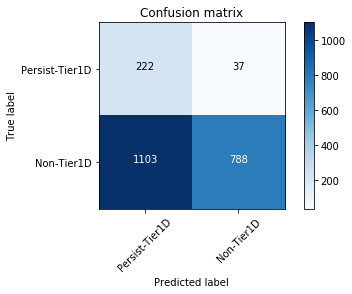

In [29]:
# {'C': 10, 'dual': True, 'penalty': 'l2'}
svc = LinearSVC(dual=True, C=10, penalty='l2')
svc.fit(X_train, y_train)
y_predict = svc.predict(X_test)
func.plot_confusion_matrix(confusion_matrix(y_test, y_predict, labels=labels), classes=labels)
print(classification_report(y_test, y_predict, labels=labels, target_names=labels))

Confusion matrix, without normalization
[[ 233  166]
 [ 508 1491]]
             precision    recall  f1-score   support

     Tier1D       0.31      0.58      0.41       399
 Non-Tier1D       0.90      0.75      0.82      1999

avg / total       0.80      0.72      0.75      2398



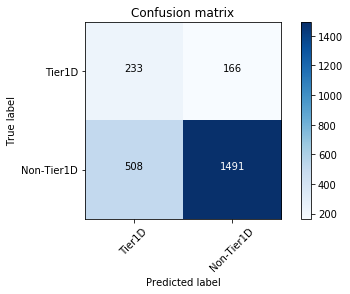

In [ ]:
# {'C': 0.1, 'dual': False, 'penalty': 'l2'}
lg = LogisticRegression(C=0.1, dual=False, )
rf.fit(X_train, y_train)
y_predict = rf.predict(X_test)
func.plot_confusion_matrix(confusion_matrix(y_test, y_predict, labels=labels), classes=labels)
print(classification_report(y_test, y_predict, labels=labels, target_names=labels))

In [27]:
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
Xs = sel.fit_transform(X)
Xsf = X.columns[sel.variances_ > .8 * (1 - .8)].tolist()
Xs = pd.DataFrame(Xs, columns=Xsf)

In [29]:
X.shape

(10888, 154)

In [30]:
Xs.head()

,A1,B6,C6H,C6L,D10A,D10I,D4M,D6A,D9G,D9L,...,H13AOFFSITE,H13AVOLUME,H13BVOLUME,H13CVOLUME,H16,H3,LUST_ELIGIBLE_NO,LUST_ELIGIBLE_UNKNOWN,STAFF_UNASSIGNED,PETROLEUM
0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,25.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,100.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,250.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


### PCA

In [17]:
pca = PCA(n_components=10)
Xpca = pca.fit_transform(X)

In [18]:
np.cumsum(pca.explained_variance_ratio_)

array([ 0.76038212,  0.85041021,  0.90658705,  0.93995279,  0.96008573,
        0.97190767,  0.98024974,  0.98487089,  0.98822489,  0.99101516])